In [1]:
from malab import *
from os.path import join
from glob import glob
from malab.dsfit import *
import os 
from numpy import *
from tempfile import TemporaryFile
%matplotlib inline
from matplotlib.pyplot import *
from scipy.signal import savgol_filter
import scipy.constants as constants
from qutip import *

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

from malab.dsfit import fithanger_new_withQc
from flux_and_freq_conversions import *

No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not load InstrumentManagerWindow


There are two main kinds of functions we will be using to grab the dac values and their associated frequencies:
- estimate flux: where you input the desired frequencies and dc coil value and it spits out the flux values
    - notes: can only take in one point at a time, is slower, not as accurate
- estimate freq: where you instead input desired flux values and it spits out the frequencies
    - notes: can take in an array of values, is faster, and more accurate


My ideal flow for using these two functions:
1. use the flux estimation to get an idea of the lower and upper limit of fluxes for the desired frequency range
2. use the freq estimation to get the freqs for a set of dac values → ideally you should be sweeping a continuous linspace, but can do a piece by piece setup if needed
3. convert these dac values to a corrected version with the crosstalk correction matrix

# Avoided crossing example

Lets work through an example where we are trying to generate the DAC values and frequencies for an avoided crossing experiment. This can generalize to most use cases and variants of sweeping qubit frequncy.

Say we are aiming to do this centered at 4.3 GHz with +/- 50 MHz around it

First we will find our upper and lower limit DAC values by using the flux estimator

In [11]:
# freqs = [dc_coil, q0, q1, q2, q3, q4, q5, q6, q7] mA
dc_coil = 0.4
freq_sweep_range = 0.05 # GHz
target_freq = 4.3
# detuning the other qubits away to 5.2 GHz
upper_freqs = [target_freq+freq_sweep_range - 0.12, 4.3, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2]
lower_freqs = [target_freq-freq_sweep_range - 0.12, 4.3, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2]

print(upper_freqs)
print(lower_freqs)

[4.2299999999999995, 4.3, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2]
[4.13, 4.3, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2]


## upper estimate

Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
Intersection points: [(-11.946666666666667, 4.2299999999999995), (-1.8666666666666654, 4.2299999999999995), (16.053333333333335, 4.2299999999999995), (26.13333333333334, 4.2299999999999995)]
Potential flux values: [-1.8666666666666654] mA



Qubit  1
Ec = 2*pi* 0.21118  GHz
Ej = 2*pi* 17.929310033147082  GHz
d =  0.4967020246161658
Ec/Ej =  84.90060627496487
DC coil flux offset shift:  0.13793103448275862
Intersection points: [(-15.252, 4.3), (-2.1080000000000023, 4.3), (21.948000000000008, 4.3), (35.092000000000006, 4.3)]
Potential flux values: [-2.1080000000000023] mA



Qubit  2
Ec = 2*pi* 0.20584  GHz
Ej = 2*pi* 18.45906891007579  GHz
d =  0.46007114506817975
Ec/Ej =  89.67678250133983
DC coil flux offset shift:  0.14814814814814814
Intersection points: [(4.333333333333336, 5.2), (10.400000000000002, 5.2), (36.833333333

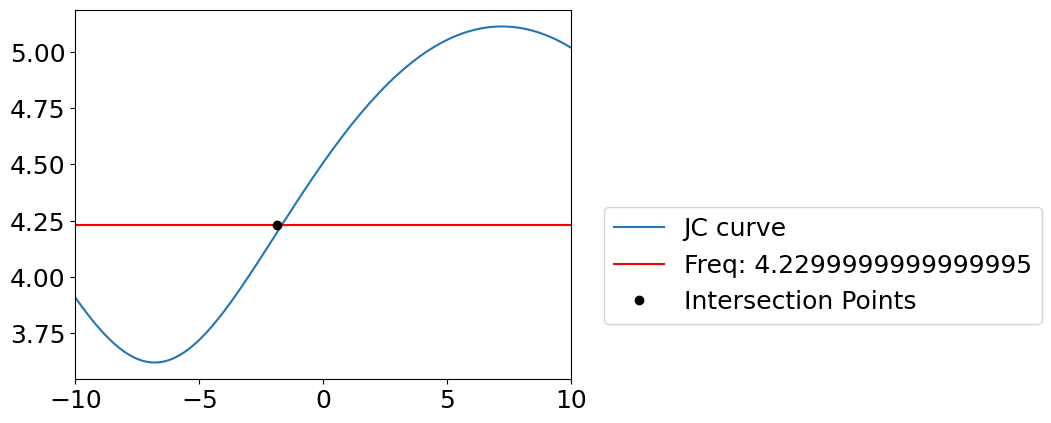

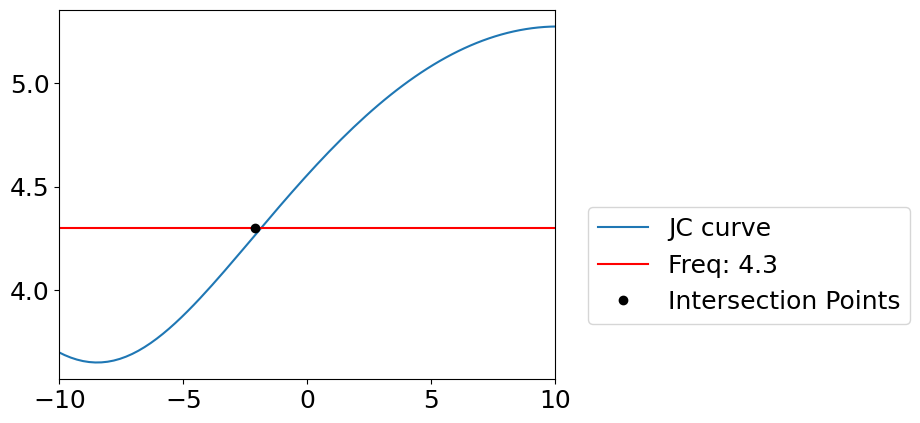

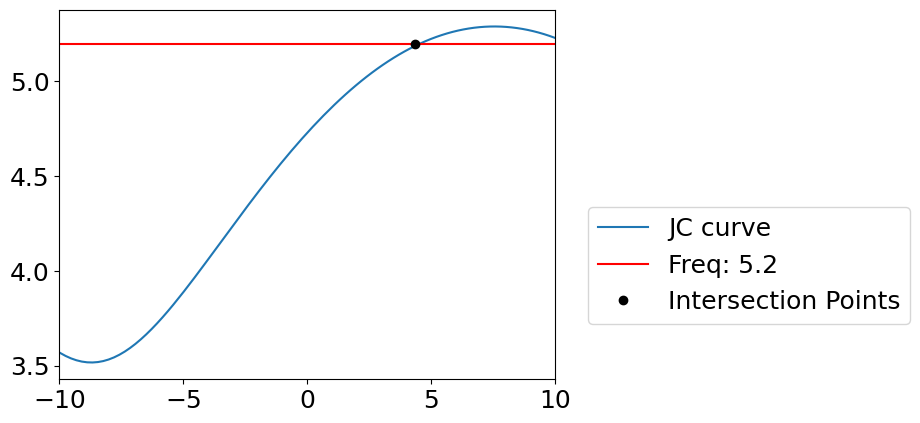

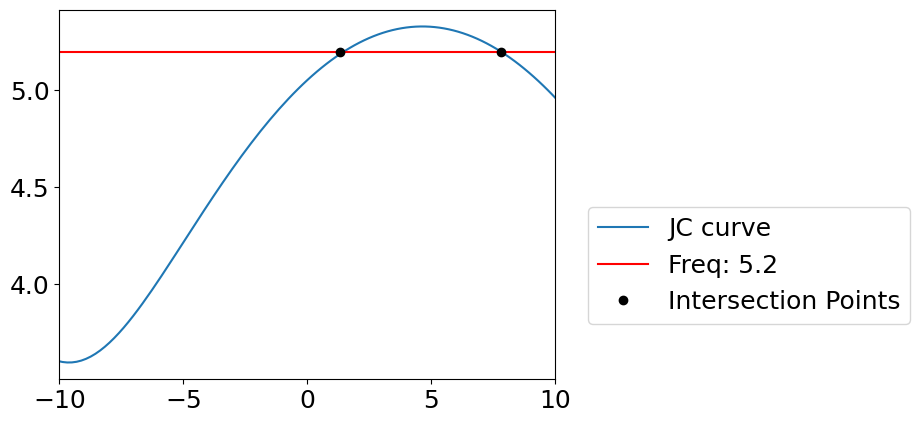

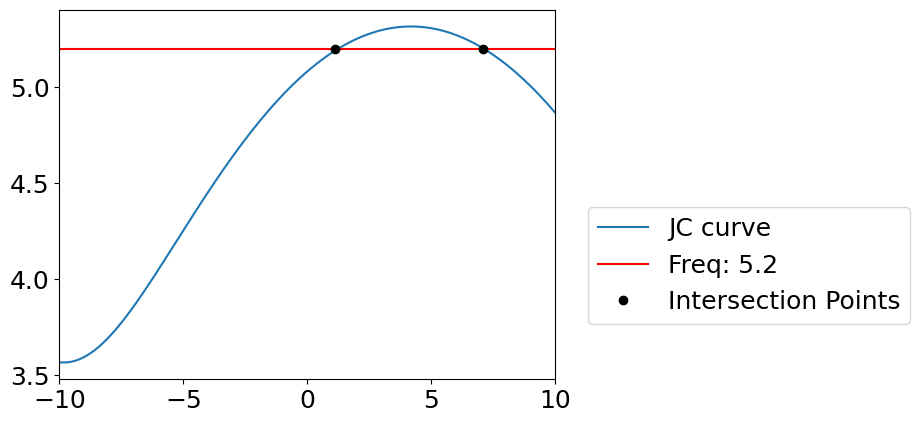

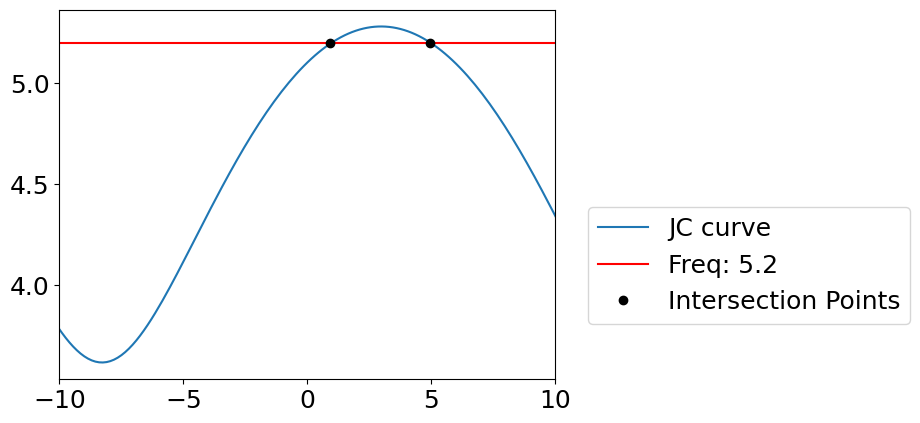

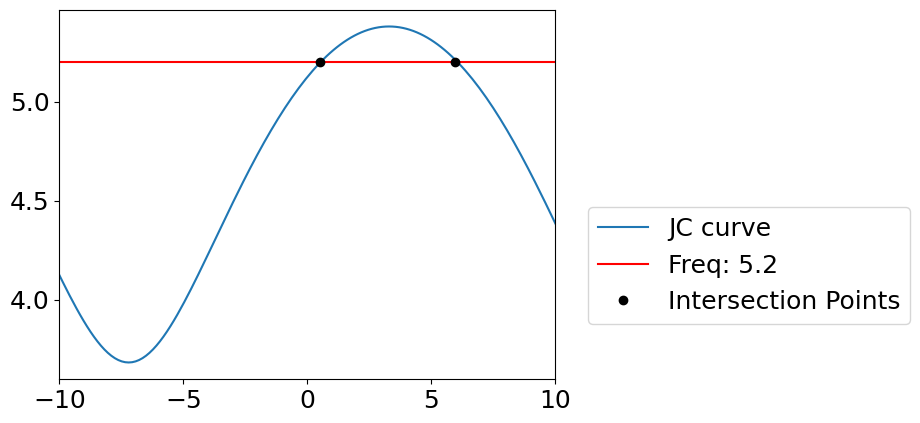

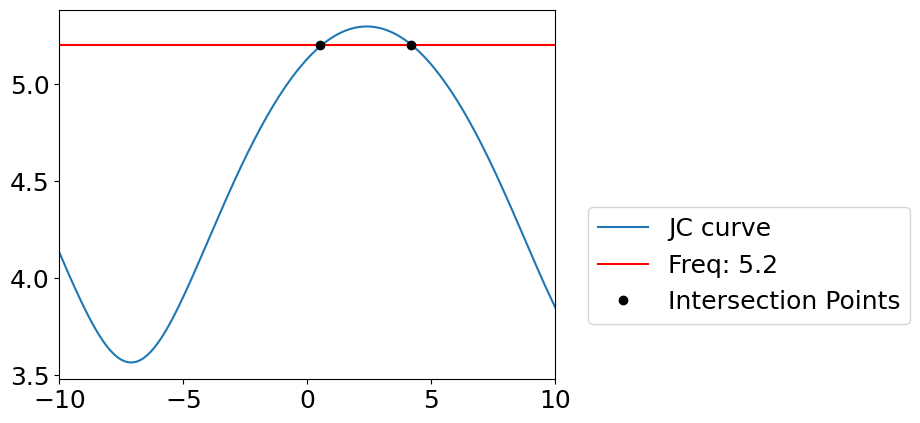

In [12]:
upper_dacs_estimate = estimate_fluxes(upper_freqs, dc_coil)

In [13]:
print(upper_dacs_estimate)

upper_pt_target = []
print('DC coil value: '+str(dc_coil)+' mA')
upper_pt_target.append(dc_coil)
for ii,q in enumerate(upper_dacs_estimate):
    print('Qubit '+str(ii)+' min DAC value: '+str(min(q, key=abs))+' mA')
    upper_pt_target.append(min(q, key=abs))
print('pt_target: ', upper_pt_target)

[[-1.8666666666666654], [-2.1080000000000023], [4.333333333333336], [1.3300000000000018, 7.790000000000002], [1.1200000000000028, 7.093333333333335], [0.9000000000000012, 4.950000000000002], [0.4900000000000011, 5.950000000000001], [0.5066666666666677, 4.1800000000000015]]
DC coil value: 0.4 mA
Qubit 0 min DAC value: -1.8666666666666654 mA
Qubit 1 min DAC value: -2.1080000000000023 mA
Qubit 2 min DAC value: 4.333333333333336 mA
Qubit 3 min DAC value: 1.3300000000000018 mA
Qubit 4 min DAC value: 1.1200000000000028 mA
Qubit 5 min DAC value: 0.9000000000000012 mA
Qubit 6 min DAC value: 0.4900000000000011 mA
Qubit 7 min DAC value: 0.5066666666666677 mA
pt_target:  [0.4, -1.8666666666666654, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677]


Here I'm picking the min absolute value for the DACs to avoid heating. However, I would prefer a continous change in DAC values rather than always having the min value, so I usually just use this as an estimate and then pick what the other limit should be based on what makes sense. In rare cases this min value approximation will break down then.

Great! Lets check this by pluggin it back into estimate freq

Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.32380952380952377
Frequency:  4.198117387547004


Qubit  1
Ec = 2*pi* 0.21118  GHz
Ej = 2*pi* 17.929310033147082  GHz
d =  0.4967020246161658
Ec/Ej =  84.90060627496487
DC coil flux offset shift:  0.13793103448275862
-0.32873563218390806
Frequency:  4.266519130095484


Qubit  2
Ec = 2*pi* 0.20584  GHz
Ej = 2*pi* 18.45906891007579  GHz
d =  0.46007114506817975
Ec/Ej =  89.67678250133983
DC coil flux offset shift:  0.14814814814814814
-0.09851851851851845
Frequency:  5.187053950101895


Qubit  3
Ec = 2*pi* 0.21552000000000002  GHz
Ej = 2*pi* 17.965277509279876  GHz
d =  0.4731382653506857
Ec/Ej =  83.35782066295414
DC coil flux offset shift:  0.15748031496062992
-0.11585301837270334
Frequency:  5.189214224073332


Qubit  4
Ec = 2*pi* 0.21218  GHz
Ej = 2*pi* 18.128008031152792  GHz
d =  0.46807654707247937
Ec/Ej =  85.43693

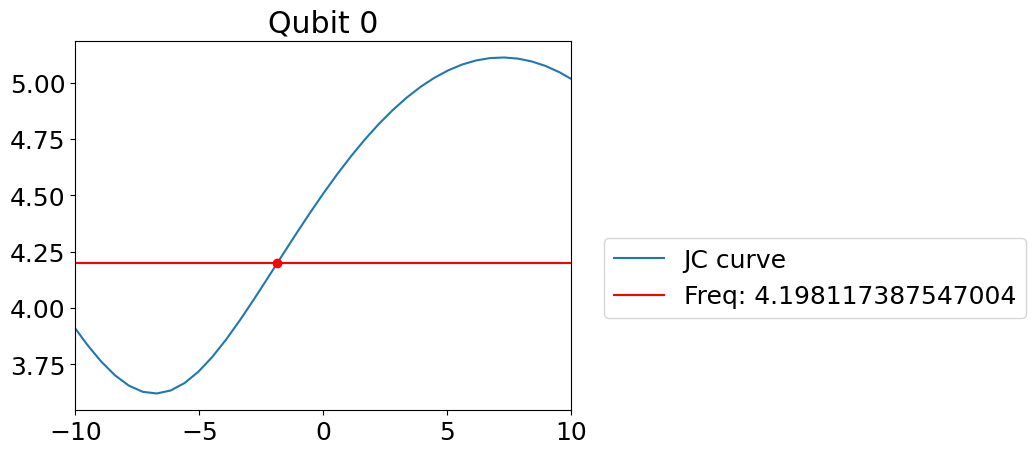

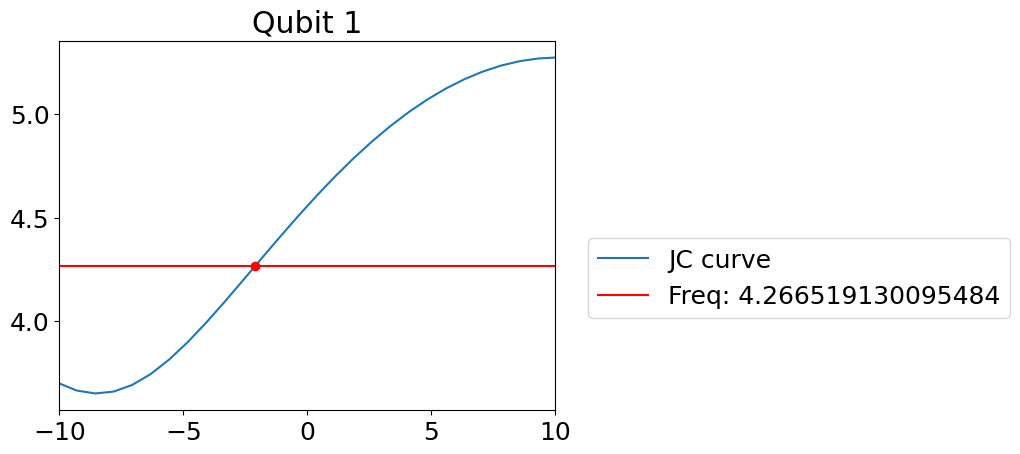

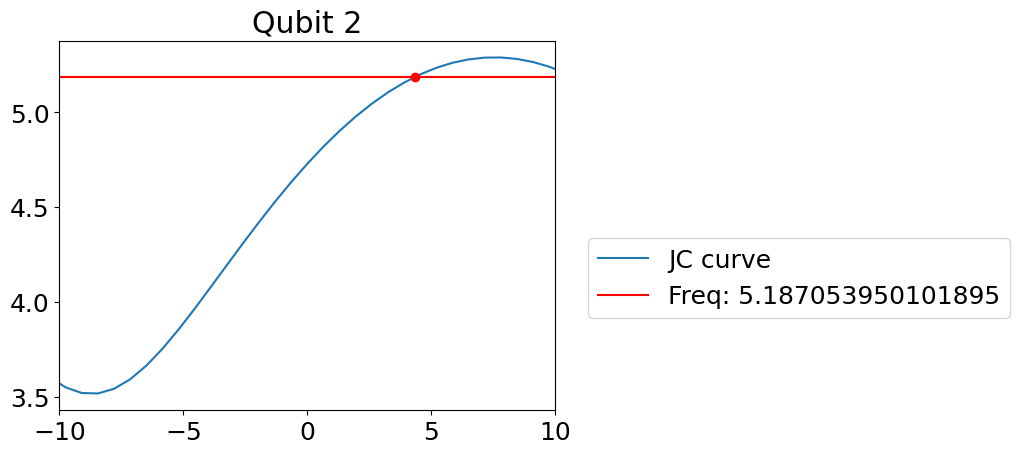

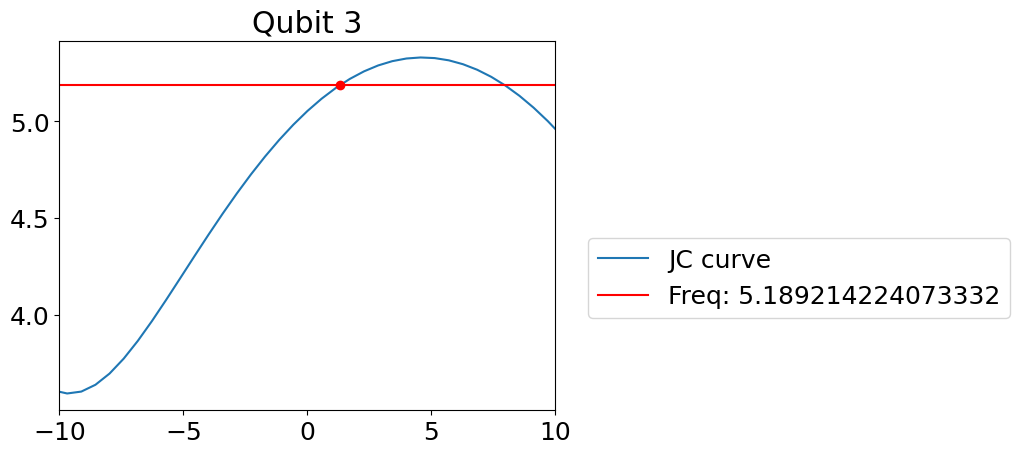

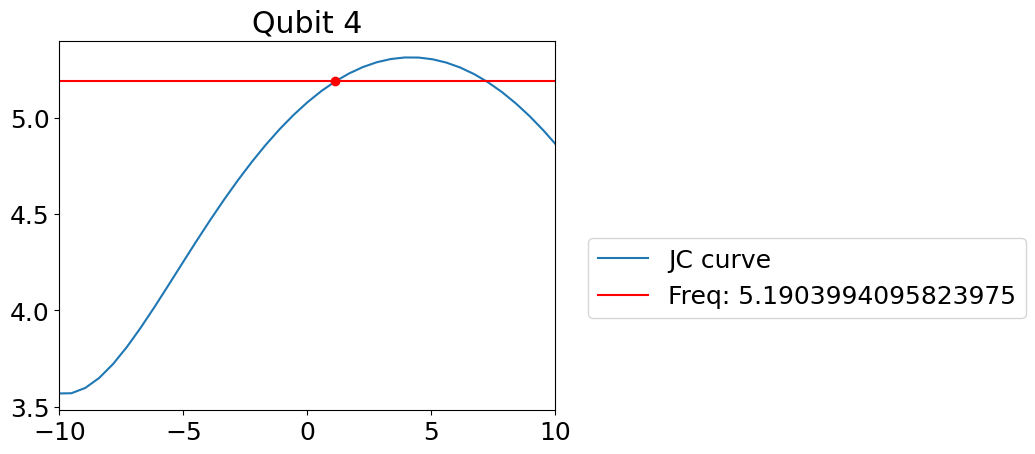

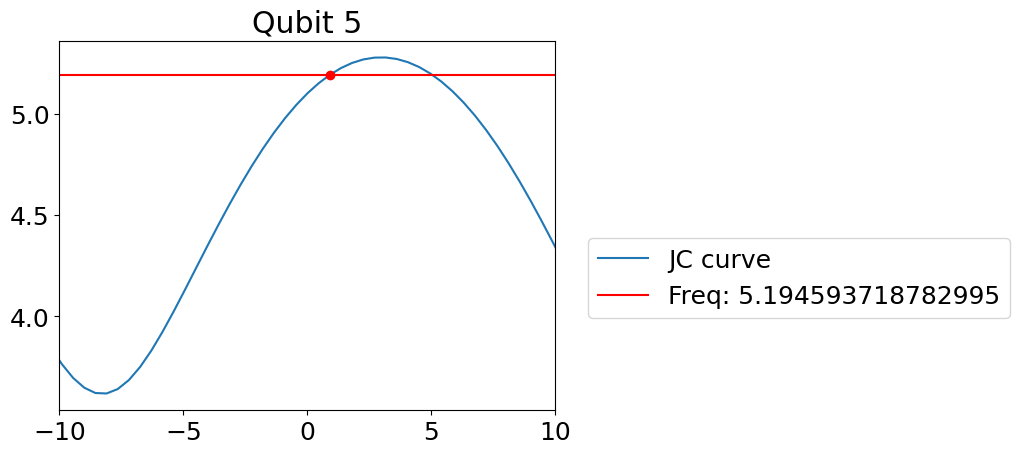

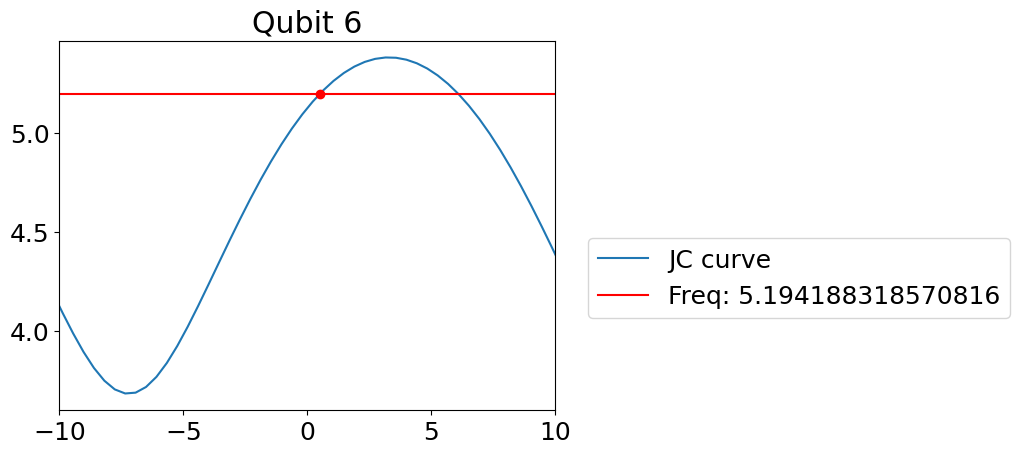

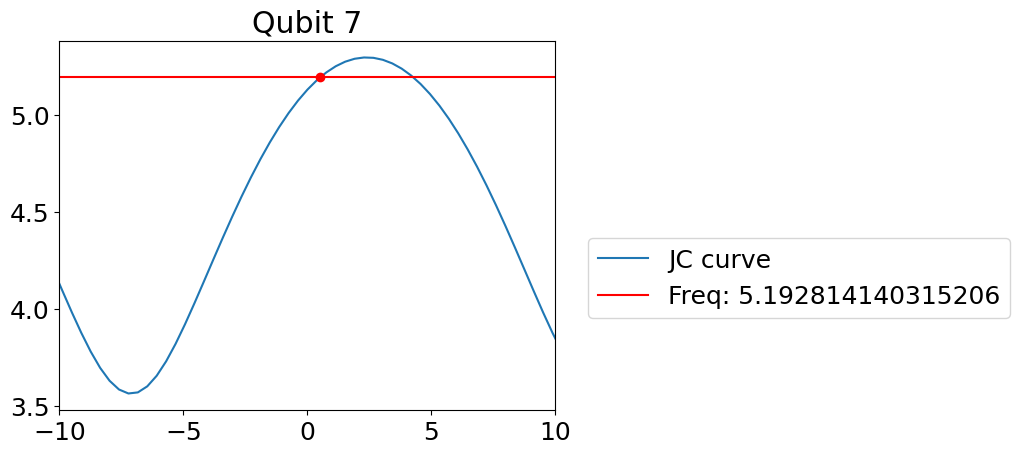

In [14]:
upper_freqs_estimate = estimate_freqs([upper_pt_target])

(3.5, 5.5)

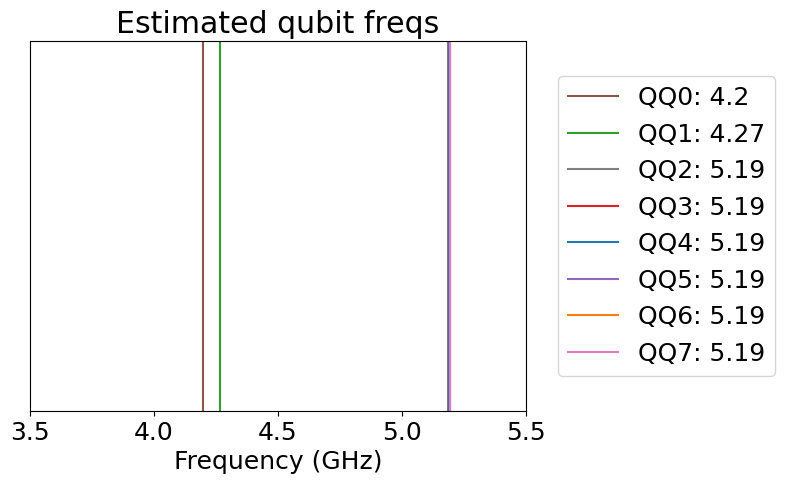

In [15]:
figure()
for ii,x in enumerate(upper_freqs_estimate[0]):
    axvline(x, color = 'C'+str(qubit_order[2][ii]), label = 'Q''Q'+str(ii)+': '+str(round(x,2)))
legend(bbox_to_anchor = (1.04,0.5),loc = 'center left')
tick_params(axis='y', left=False, labelleft=False)
xlabel('Frequency (GHz)')
title('Estimated qubit freqs')
xlim(3.5, 5.5)

We can see that the estimate is pretty close but not super exact. Its still a good starting point for our dac array. Now lets do the same with the lower limit.

## lower estimate

Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
Intersection points: [(-11.386666666666665, 4.13), (-2.426666666666664, 4.13), (16.613333333333337, 4.13), (25.573333333333338, 4.13)]
Potential flux values: [-2.426666666666664] mA



Qubit  1
Ec = 2*pi* 0.21118  GHz
Ej = 2*pi* 17.929310033147082  GHz
d =  0.4967020246161658
Ec/Ej =  84.90060627496487
DC coil flux offset shift:  0.13793103448275862
Intersection points: [(-15.252, 4.3), (-2.1080000000000023, 4.3), (21.948000000000008, 4.3), (35.092000000000006, 4.3)]
Potential flux values: [-2.1080000000000023] mA



Qubit  2
Ec = 2*pi* 0.20584  GHz
Ej = 2*pi* 18.45906891007579  GHz
d =  0.46007114506817975
Ec/Ej =  89.67678250133983
DC coil flux offset shift:  0.14814814814814814
Intersection points: [(4.333333333333336, 5.2), (10.400000000000002, 5.2), (36.833333333333336, 5.2), (42.900000000000006, 5.2)]
Potential flux v

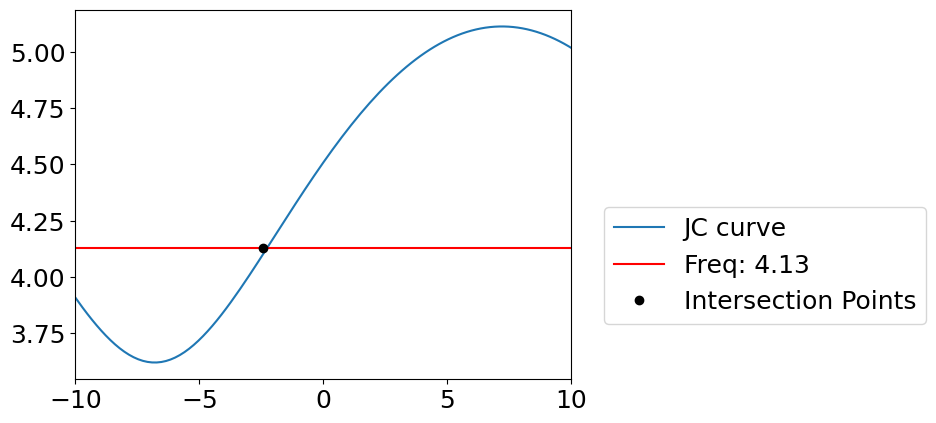

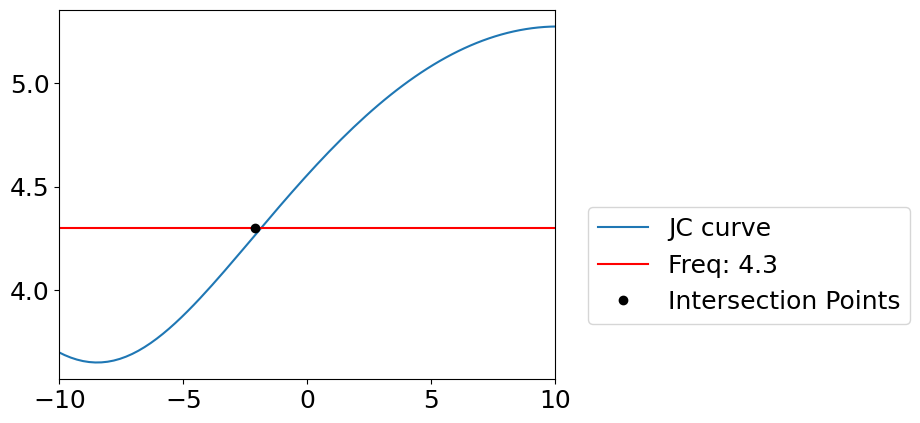

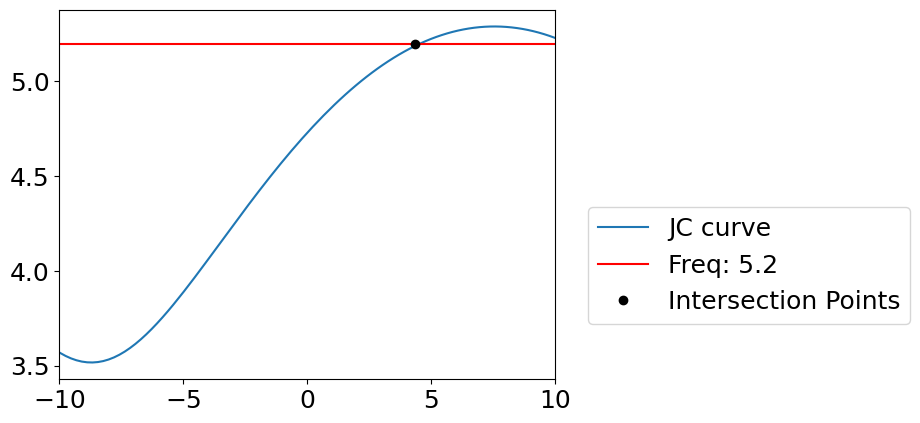

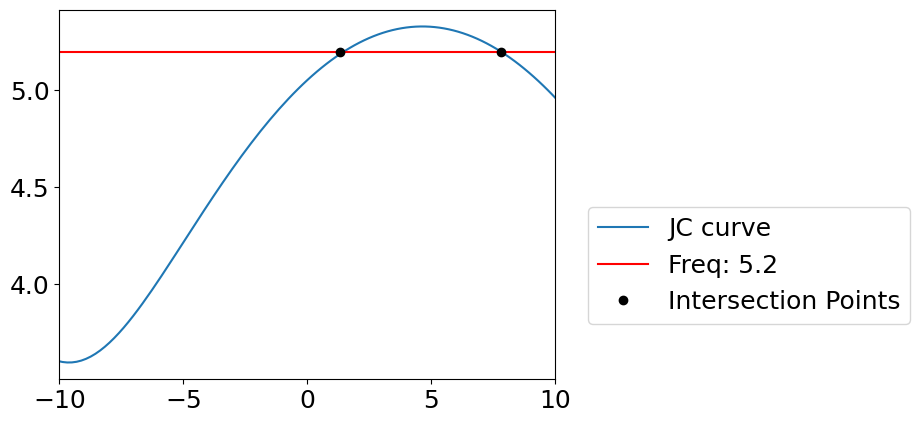

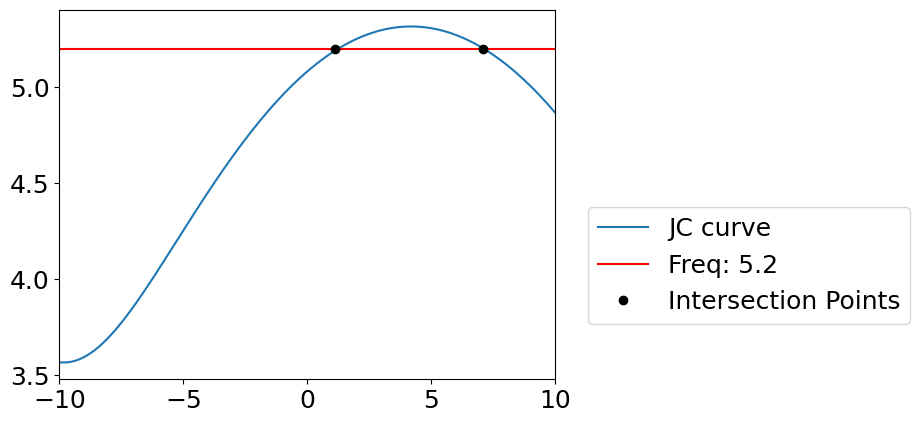

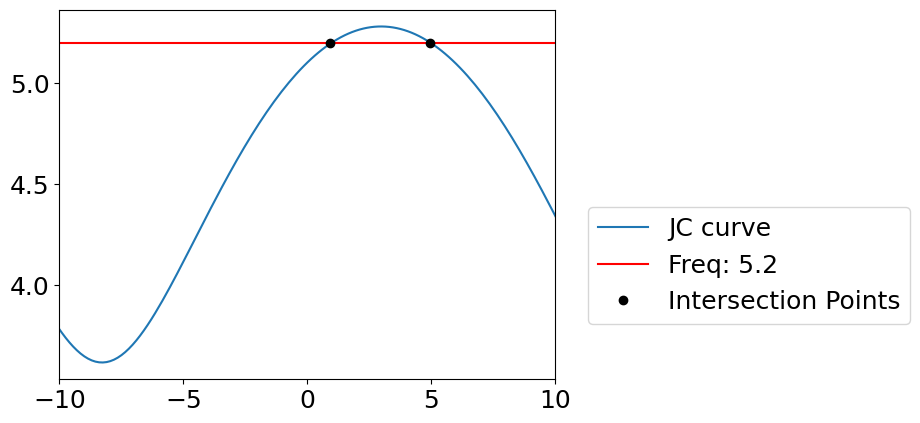

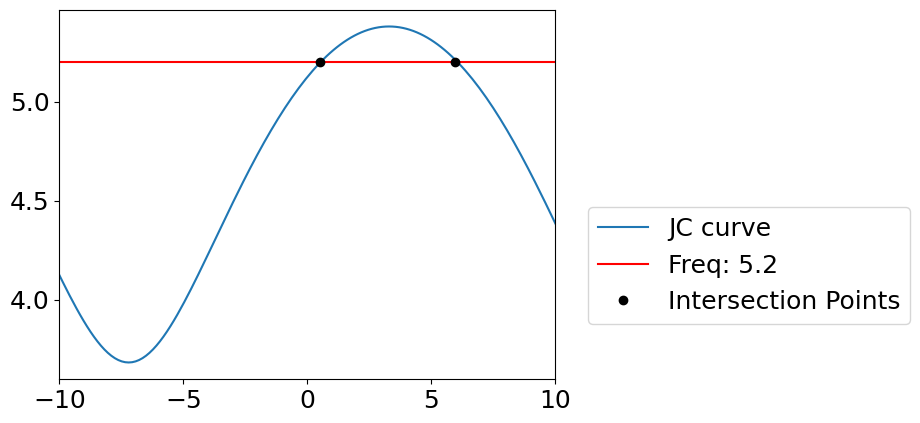

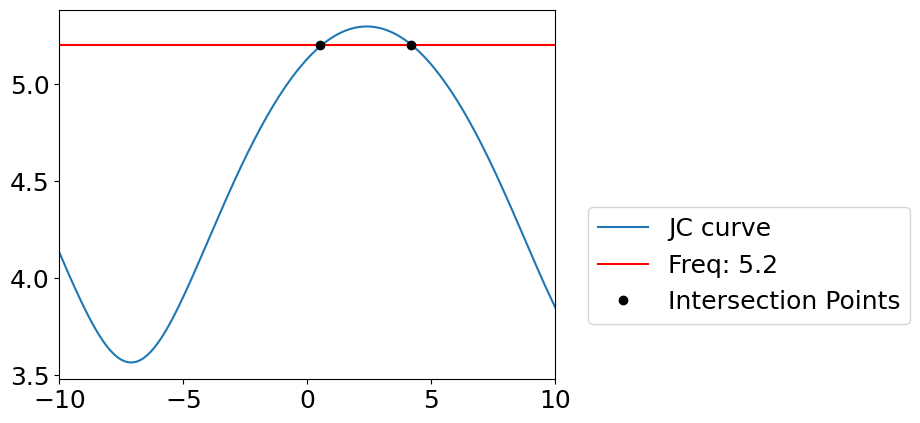

In [16]:
lower_dacs_estimate = estimate_fluxes(lower_freqs, dc_coil)

In [17]:
print(lower_dacs_estimate)

lower_pt_target = []
print('DC coil value: '+str(dc_coil)+' mA')
lower_pt_target.append(dc_coil)
for ii,q in enumerate(lower_dacs_estimate):
    print('Qubit '+str(ii)+' min DAC value: '+str(min(q, key=abs))+' mA')
    lower_pt_target.append(min(q, key=abs))
print('pt_target: ', lower_pt_target)

[[-2.426666666666664], [-2.1080000000000023], [4.333333333333336], [1.3300000000000018, 7.790000000000002], [1.1200000000000028, 7.093333333333335], [0.9000000000000012, 4.950000000000002], [0.4900000000000011, 5.950000000000001], [0.5066666666666677, 4.1800000000000015]]
DC coil value: 0.4 mA
Qubit 0 min DAC value: -2.426666666666664 mA
Qubit 1 min DAC value: -2.1080000000000023 mA
Qubit 2 min DAC value: 4.333333333333336 mA
Qubit 3 min DAC value: 1.3300000000000018 mA
Qubit 4 min DAC value: 1.1200000000000028 mA
Qubit 5 min DAC value: 0.9000000000000012 mA
Qubit 6 min DAC value: 0.4900000000000011 mA
Qubit 7 min DAC value: 0.5066666666666677 mA
pt_target:  [0.4, -2.426666666666664, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677]


Great! Lets check this by pluggin it back into estimate freq

Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.3438095238095237
Frequency:  4.101963012485574


Qubit  1
Ec = 2*pi* 0.21118  GHz
Ej = 2*pi* 17.929310033147082  GHz
d =  0.4967020246161658
Ec/Ej =  84.90060627496487
DC coil flux offset shift:  0.13793103448275862
-0.32873563218390806
Frequency:  4.266519130095484


Qubit  2
Ec = 2*pi* 0.20584  GHz
Ej = 2*pi* 18.45906891007579  GHz
d =  0.46007114506817975
Ec/Ej =  89.67678250133983
DC coil flux offset shift:  0.14814814814814814
-0.09851851851851845
Frequency:  5.187053950101895


Qubit  3
Ec = 2*pi* 0.21552000000000002  GHz
Ej = 2*pi* 17.965277509279876  GHz
d =  0.4731382653506857
Ec/Ej =  83.35782066295414
DC coil flux offset shift:  0.15748031496062992
-0.11585301837270334
Frequency:  5.189214224073332


Qubit  4
Ec = 2*pi* 0.21218  GHz
Ej = 2*pi* 18.128008031152792  GHz
d =  0.46807654707247937
Ec/Ej =  85.436931

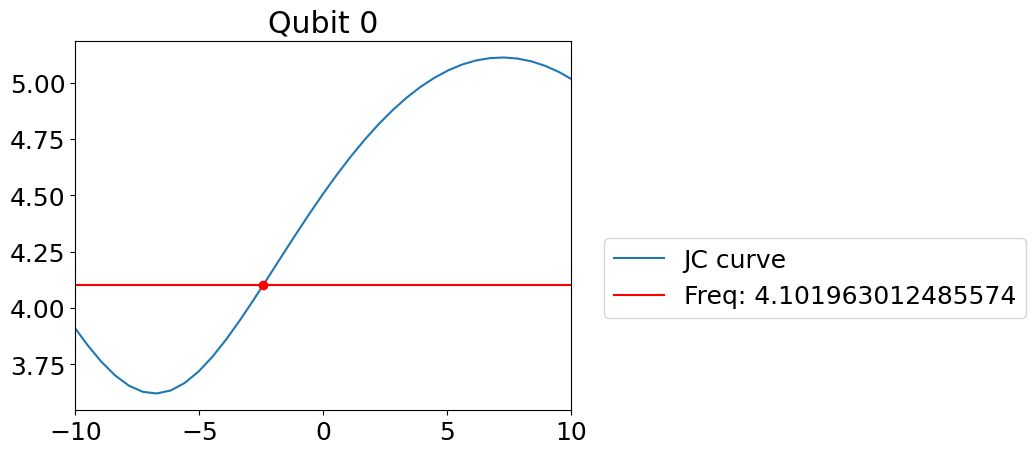

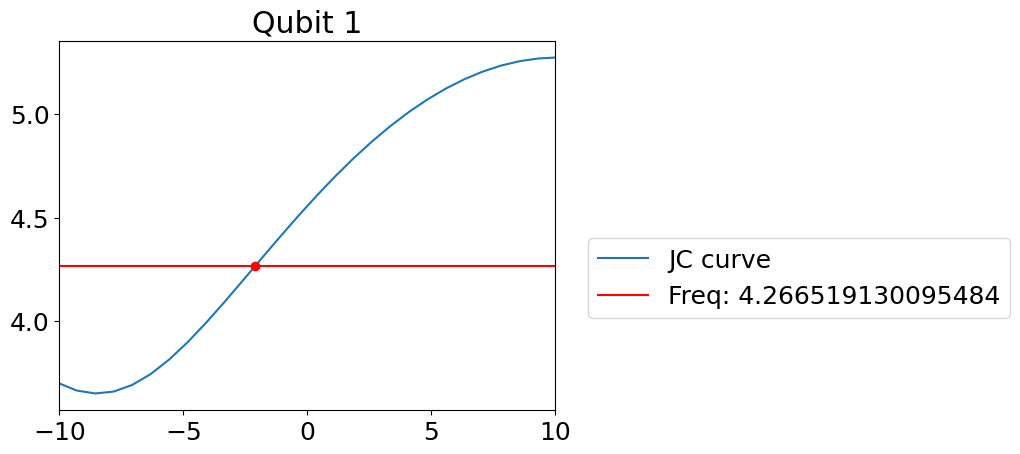

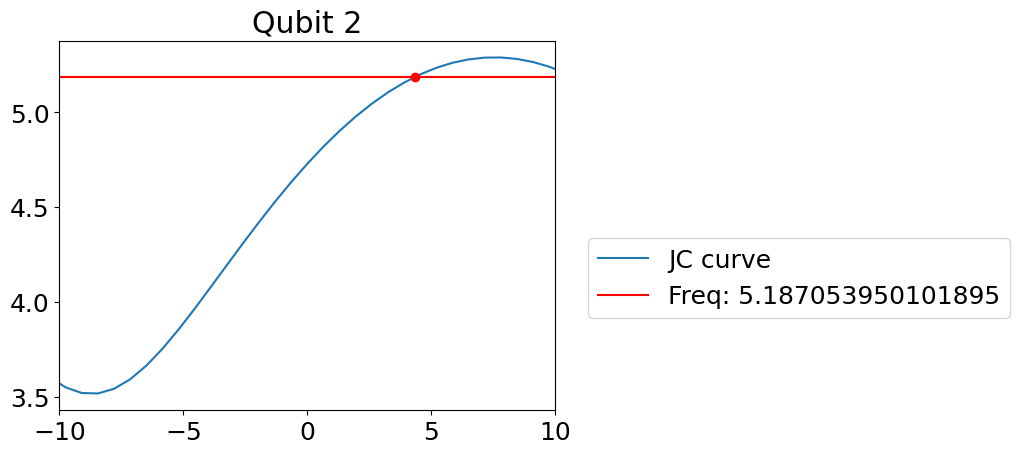

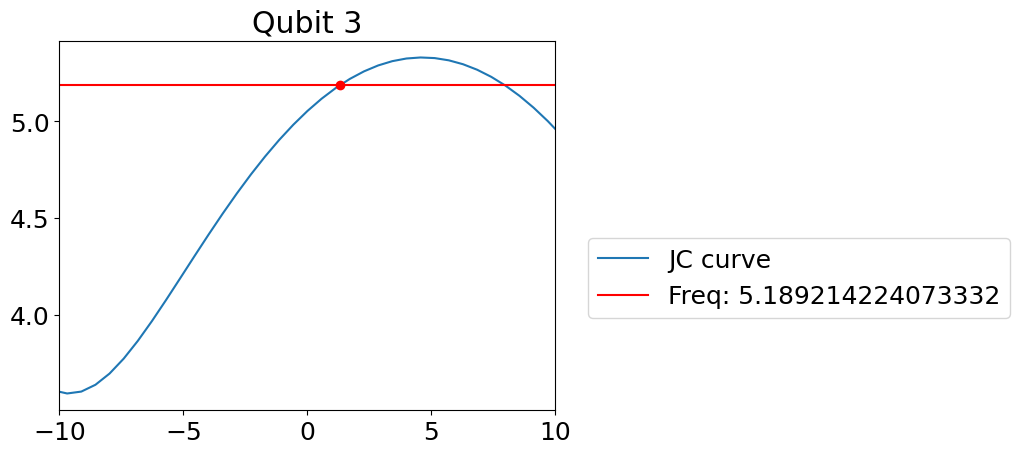

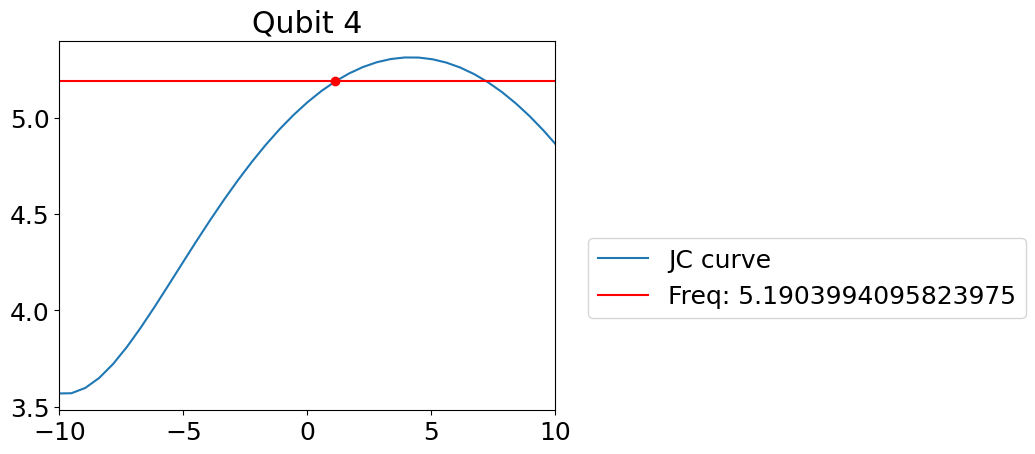

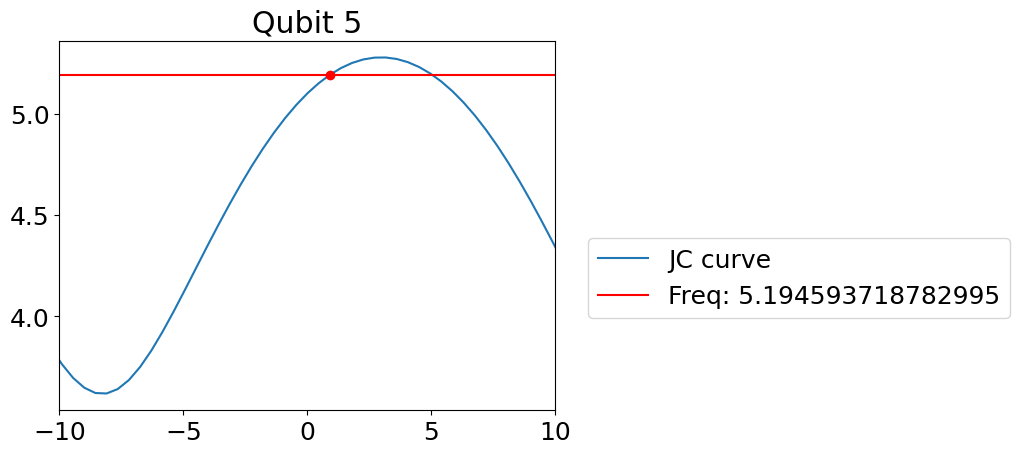

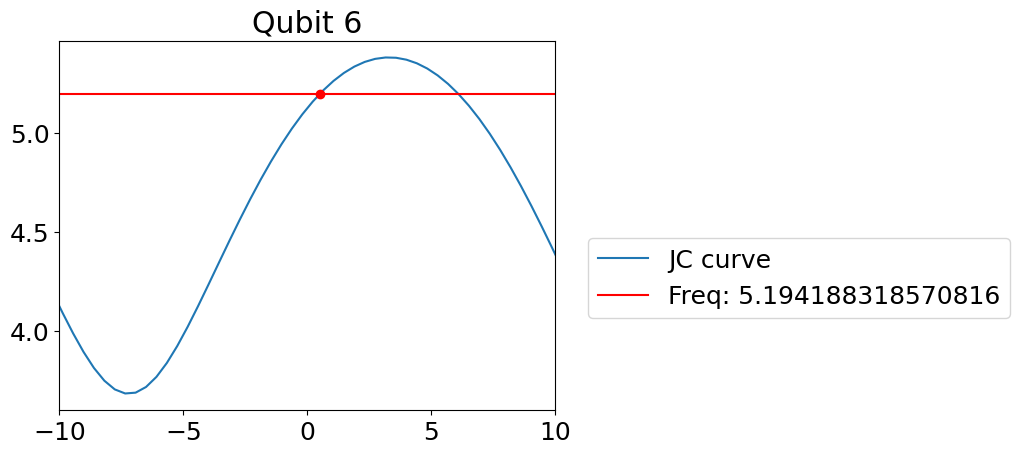

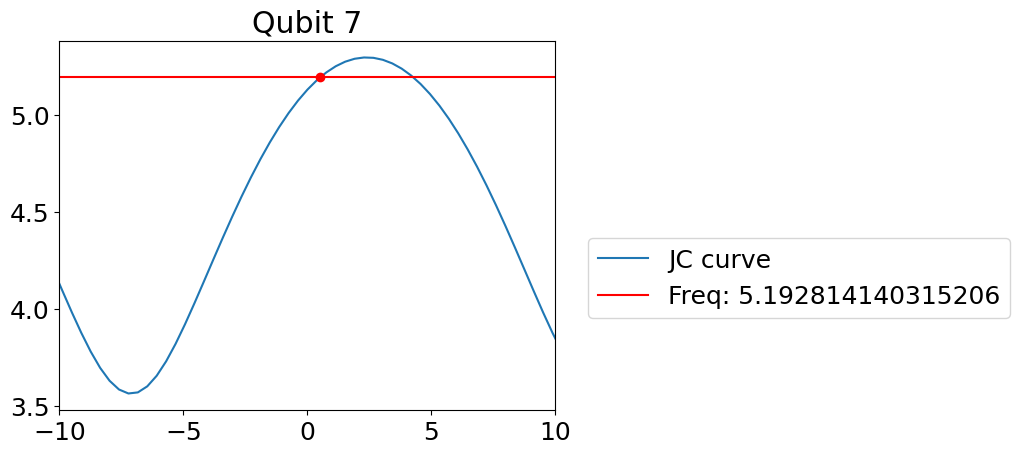

In [18]:
lower_freqs_estimate = estimate_freqs([lower_pt_target])

(3.5, 5.5)

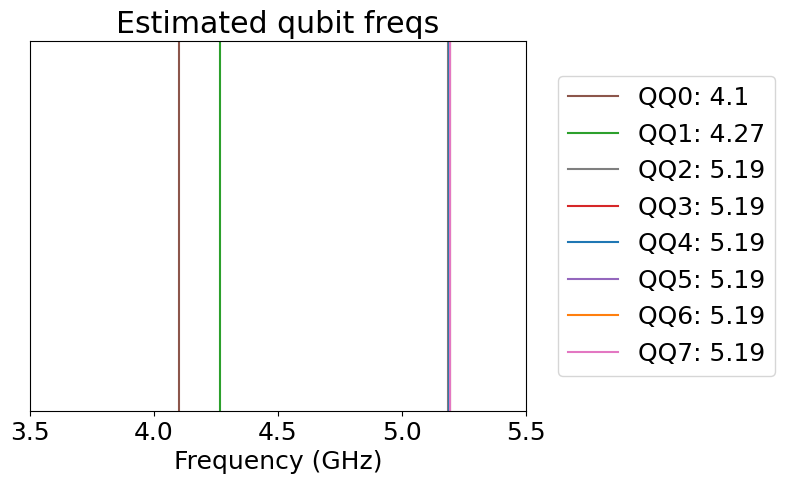

In [19]:
figure()
for ii,x in enumerate(lower_freqs_estimate[0]):
    axvline(x, color = 'C'+str(qubit_order[2][ii]), label = 'Q''Q'+str(ii)+': '+str(round(x,2)))
legend(bbox_to_anchor = (1.04,0.5),loc = 'center left')
tick_params(axis='y', left=False, labelleft=False)
xlabel('Frequency (GHz)')
title('Estimated qubit freqs')
xlim(3.5, 5.5)

## Creating the DAC value sweep

In [20]:
print(upper_pt_target)
print(lower_pt_target)

[0.4, -1.8666666666666654, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677]
[0.4, -2.426666666666664, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677]


Notice how only Q0's DAC value shifted. This calculation doesn't include any crosstalk calculation, so you should expect each line to not affect each other, hence since we are only changing Q0 we only see that value differ.

We will add the crosstalk correction in at the end.

Now, we want a coarse sweep of Q0's freq for now, say 2 MHz, so with a 100 MHz range (+/- 50) we want 50 points between the two dac values.

In [21]:
# pt_target = [dc_coil, q0, q1, q2, q3, q4, q5, q6, q7]
q0_dac_range = linspace(upper_pt_target[1], lower_pt_target[1], 50)
print(q0_dac_range)

[-1.86666667 -1.87809524 -1.88952381 -1.90095238 -1.91238095 -1.92380952
 -1.9352381  -1.94666667 -1.95809524 -1.96952381 -1.98095238 -1.99238095
 -2.00380952 -2.0152381  -2.02666667 -2.03809524 -2.04952381 -2.06095238
 -2.07238095 -2.08380952 -2.0952381  -2.10666667 -2.11809524 -2.12952381
 -2.14095238 -2.15238095 -2.16380952 -2.1752381  -2.18666667 -2.19809524
 -2.20952381 -2.22095238 -2.23238095 -2.24380952 -2.2552381  -2.26666667
 -2.27809524 -2.28952381 -2.30095238 -2.31238095 -2.32380952 -2.3352381
 -2.34666667 -2.35809524 -2.36952381 -2.38095238 -2.39238095 -2.40380952
 -2.4152381  -2.42666667]


I dont know what was happening below but python made me do like this double duplication thing for the .append() to work

In [22]:
temp = copy(upper_pt_target).tolist()

In [23]:
pt_array = []

for x in q0_dac_range:
    temp[1]=x
    # print(temp)
    temp2 = copy(temp).tolist()
    pt_array.append(temp2)
    # print('what is happening?')

print(pt_array)

q0_freqs_array = estimate_freq(pt_array, 0, plotting=0)

[[0.4, -1.8666666666666654, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.8780952380952367, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.8895238095238083, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.9009523809523796, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.912380952380951, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.9238095238095223, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.50666666666

In [24]:
q0_freqs_array

[4.198117387547004,
 4.196151290008469,
 4.1941851029221535,
 4.192218841275774,
 4.190252520118496,
 4.188286154559437,
 4.186319759780923,
 4.184353351016731,
 4.182386943581768,
 4.180420552826619,
 4.178454194181834,
 4.176487883153697,
 4.174521635297426,
 4.172555466222903,
 4.170589391632055,
 4.168623427261698,
 4.1666575889359505,
 4.164691892537038,
 4.162726354001104,
 4.160760989349597,
 4.158795814648378,
 4.1568308460408,
 4.154866099735402,
 4.152901592003368,
 4.150937339180873,
 4.1489733576711885,
 4.147009663944211,
 4.145046274537338,
 4.143083206044795,
 4.141120475151066,
 4.139158098569814,
 4.137196093117457,
 4.135234475657736,
 4.133273263127368,
 4.131312472517946,
 4.129352120913132,
 4.127392225438637,
 4.125432803302499,
 4.123473871777023,
 4.121515448197978,
 4.119557549975509,
 4.117600194576218,
 4.115643399549453,
 4.113687182498884,
 4.111731561105523,
 4.109776553115827,
 4.10782217634204,
 4.1058684486667305,
 4.103915388040908,
 4.101963012485574]

So this isn't super exact, so we need to either move the range or move Q1 to the center frequency.

Lets move the range..

## Moving the DAC sweep range if needed

In [25]:
print(pt_array[0][1])

-1.8666666666666654


Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.31785714285714284
Frequency:  4.22677022596965



Array of freqs:
[4.22677022596965]





[4.22677022596965]

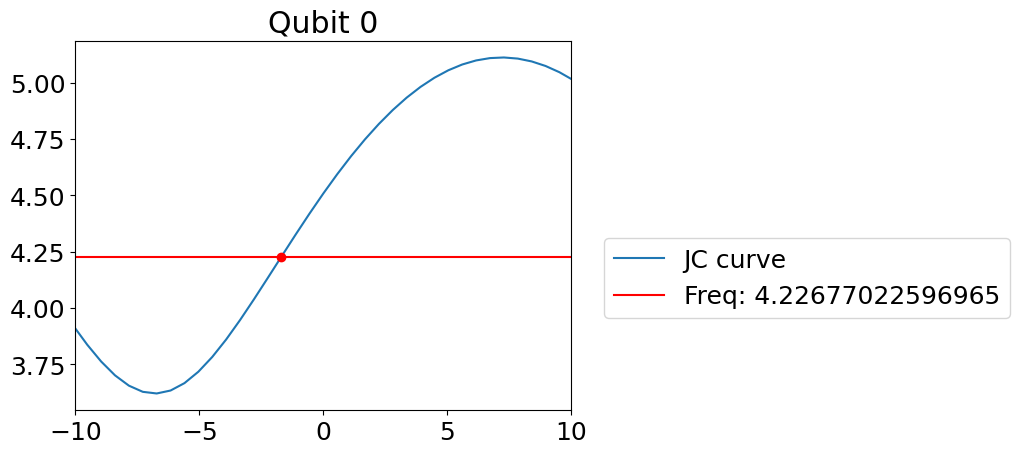

In [36]:
pt_array[0][1]= -1.7
estimate_freq([pt_array[0]], 0)

In [37]:
print(pt_array[-1][1])

-2


Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.33571428571428574
Frequency:  4.140793387330354



Array of freqs:
[4.140793387330354]





[4.140793387330354]

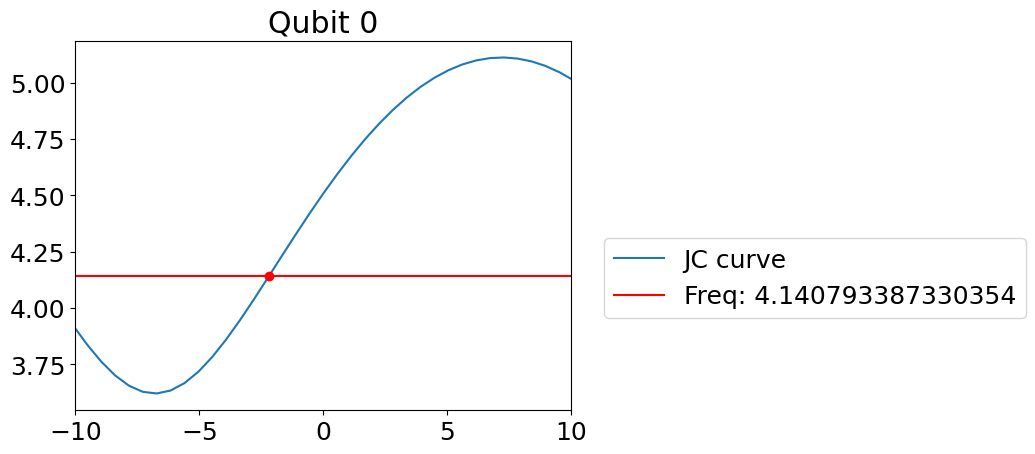

In [40]:
pt_array[-1][1]= -2.2
estimate_freq([pt_array[-1]], 0)

In [29]:
q0_dac_range = linspace(-1.005, -1.565, 50) # hardcoded this just in case I reset the value

In [41]:
q0_dac_range = linspace(-1.7, -2.2, 50) # hardcoded this just in case I reset the value

In [42]:
for ii, x in enumerate(q0_dac_range):
    pt_array[ii][1] = x

print(pt_array)

[[0.4, -1.7, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.710204081632653, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.720408163265306, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.730612244897959, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.7408163265306122, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.7510204081632652, -2.1080000000000023, 4.333333333333336, 1.3300000000000018, 1.1200000000000028, 0.9000000000000012, 0.4900000000000011, 0.5066666666666677], [0.4, -1.

In [43]:
q0_freqs_array = estimate_freq(pt_array, 0, plotting=0)

Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.31785714285714284
Frequency:  4.22677022596965



Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.3182215743440233
Frequency:  4.22501744810713



Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.3185860058309038
Frequency:  4.223264429015854



Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux offset shift:  0.14285714285714288
-0.3189504373177843
Frequency:  4.221511178731407



Qubit  0
Ec = 2*pi* 0.21756  GHz
Ej = 2*pi* 16.43017900441257  GHz
d =  0.5201980476423896
Ec/Ej =  75.5202197297875
DC coil flux

In [44]:
q0_freqs_array

[4.22677022596965,
 4.22501744810713,
 4.223264429015854,
 4.221511178731407,
 4.21975770730214,
 4.218004024833274,
 4.216250141459422,
 4.214496067362128,
 4.212741812753791,
 4.210987387882741,
 4.209232803048933,
 4.207478068584513,
 4.205723194860639,
 4.2039681922821215,
 4.202213071301042,
 4.200457842404614,
 4.198702516119825,
 4.1969471030271155,
 4.19519161371204,
 4.193436058843983,
 4.191680449094961,
 4.189924795197223,
 4.188169107920334,
 4.186413398062297,
 4.184657676487396,
 4.182901954064061,
 4.18114624173222,
 4.17939055045206,
 4.1776348912463055,
 4.175879275151153,
 4.174123713259717,
 4.1723682167040455,
 4.1706127966616275,
 4.168857464337845,
 4.167102230994275,
 4.165347107920931,
 4.1635921064530494,
 4.1618372379676165,
 4.160082513887748,
 4.158327945679674,
 4.156573544837118,
 4.154819322904675,
 4.153065291471046,
 4.1513114621619955,
 4.14955784664039,
 4.147804456631285,
 4.146051303878646,
 4.144298400174763,
 4.142545757364568,
 4.140793387330354]

These values are much better, not perfect but there will be some shift between these values and the rfsoc spectroscopy results. This is good enough for an initial test.

Lets check Q1 to make sure its in the center..

## Checking the stable qubit

Qubit  1
Ec = 2*pi* 0.21118  GHz
Ej = 2*pi* 17.929310033147082  GHz
d =  0.4967020246161658
Ec/Ej =  84.90060627496487
DC coil flux offset shift:  0.13793103448275862
-0.32873563218390806
Frequency:  4.266519130095484



Array of freqs:
[4.266519130095484]





[4.266519130095484]

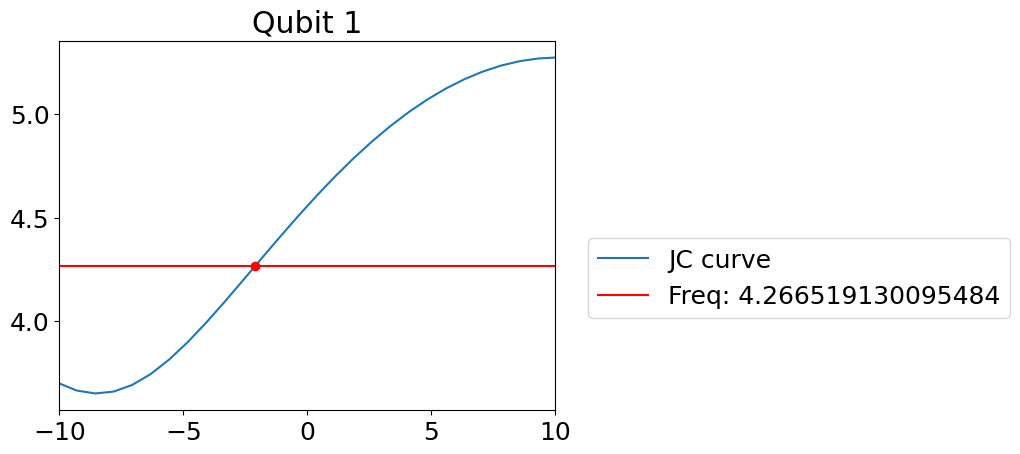

In [45]:
estimate_freq([pt_array[0]], 1)

This is decent, could be better but I am a little lazy...

## Crosstalk correction

For the correction (TRM is imported in from the .py file):

In [46]:
corrected_dac_values = []

for ii in pt_array:
    pt = np.dot(TRM,ii[1:])
    pt = np.insert(pt, 0, ii[0])
    corrected_dac_values.append(pt.tolist())

corrected_dac_values

[[0.4,
  -3.2330571958866674,
  -4.402916545800004,
  2.5978636128599994,
  0.09292706679999996,
  -0.04100943357999853,
  -0.05674391585333344,
  -0.4504618734333333,
  -0.4797057129999998],
 [0.4,
  -3.243261277519321,
  -4.405582376106127,
  2.595603105513061,
  0.09070299486122446,
  -0.04352846327387605,
  -0.05919343095537416,
  -0.4530320010863945,
  -0.4834513677959182],
 [0.4,
  -3.2534653591519738,
  -4.408248206412249,
  2.5933425981661227,
  0.08847892292244897,
  -0.04604749296775357,
  -0.06164294605741499,
  -0.45560212873945577,
  -0.48719702259183656],
 [0.4,
  -3.2636694407846267,
  -4.4109140367183715,
  2.5910820908191834,
  0.08625485098367347,
  -0.048566522661631084,
  -0.06409246115945583,
  -0.45817225639251696,
  -0.49094267738775493],
 [0.4,
  -3.27387352241728,
  -4.4135798670244935,
  2.588821583472245,
  0.08403077904489797,
  -0.05108555235550871,
  -0.06654197626149666,
  -0.4607423840455782,
  -0.4946883321836733],
 [0.4,
  -3.2840776040499327,
  -4.416

## Last remarks

Now I would reccomend checking the first and last pt_array points on the rfsoc before running the full experiment to:
1. See what the frequency shift is for the peaks and adjust the range -> should only need a fixed offset so no need to redo all this code
2. Make sure the upper and lower limits match the +/- 50 MHz range -> will need to iterate again
3. Might need to experiment with the range for qubit spectroscopy as this modelling does not take into consideration any interactions and that shifts the frequencies..

Then you can iterate it as needed using some of the code we have used above!!

Final ouputs for the rfsoc code:

In [47]:
# q1 is set to 4.267
q0_freqs_array

[4.22677022596965,
 4.22501744810713,
 4.223264429015854,
 4.221511178731407,
 4.21975770730214,
 4.218004024833274,
 4.216250141459422,
 4.214496067362128,
 4.212741812753791,
 4.210987387882741,
 4.209232803048933,
 4.207478068584513,
 4.205723194860639,
 4.2039681922821215,
 4.202213071301042,
 4.200457842404614,
 4.198702516119825,
 4.1969471030271155,
 4.19519161371204,
 4.193436058843983,
 4.191680449094961,
 4.189924795197223,
 4.188169107920334,
 4.186413398062297,
 4.184657676487396,
 4.182901954064061,
 4.18114624173222,
 4.17939055045206,
 4.1776348912463055,
 4.175879275151153,
 4.174123713259717,
 4.1723682167040455,
 4.1706127966616275,
 4.168857464337845,
 4.167102230994275,
 4.165347107920931,
 4.1635921064530494,
 4.1618372379676165,
 4.160082513887748,
 4.158327945679674,
 4.156573544837118,
 4.154819322904675,
 4.153065291471046,
 4.1513114621619955,
 4.14955784664039,
 4.147804456631285,
 4.146051303878646,
 4.144298400174763,
 4.142545757364568,
 4.140793387330354]

In [48]:
corrected_dac_values

[[0.4,
  -3.2330571958866674,
  -4.402916545800004,
  2.5978636128599994,
  0.09292706679999996,
  -0.04100943357999853,
  -0.05674391585333344,
  -0.4504618734333333,
  -0.4797057129999998],
 [0.4,
  -3.243261277519321,
  -4.405582376106127,
  2.595603105513061,
  0.09070299486122446,
  -0.04352846327387605,
  -0.05919343095537416,
  -0.4530320010863945,
  -0.4834513677959182],
 [0.4,
  -3.2534653591519738,
  -4.408248206412249,
  2.5933425981661227,
  0.08847892292244897,
  -0.04604749296775357,
  -0.06164294605741499,
  -0.45560212873945577,
  -0.48719702259183656],
 [0.4,
  -3.2636694407846267,
  -4.4109140367183715,
  2.5910820908191834,
  0.08625485098367347,
  -0.048566522661631084,
  -0.06409246115945583,
  -0.45817225639251696,
  -0.49094267738775493],
 [0.4,
  -3.27387352241728,
  -4.4135798670244935,
  2.588821583472245,
  0.08403077904489797,
  -0.05108555235550871,
  -0.06654197626149666,
  -0.4607423840455782,
  -0.4946883321836733],
 [0.4,
  -3.2840776040499327,
  -4.416